In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, random, numpy as np, pandas as pd, copy
from IPython.display import clear_output
import matplotlib.pyplot as plt

from dataset import RegressionTaskGenerator
from metalearning import MultiReptile, MultiMAML, MMAML, TSA_MAML, TaskEncoderTrainer, adapt_and_evaluate, adapt_and_evaluate_mmaml, adapt_and_evaluate_tsamaml
from models import RegressionModule, RegressionTaskEncoder, GatedNet, LSTMEmbeddingModel
from utils import DEVICE, write_in_file, evaluation_regression, plot_compare, plot_compare_sota, te_evaluation, averaging_results, n_models_comparison, plot_regression_tasks, plot_regression_results_comparison
from params_regression import *

# For reproducibility
torch.random.manual_seed(1)
np.random.seed(1)
random.seed(1)

2


In [15]:
def plot_regression_results_comparison1(X, y, X_test, y_test, histories, bestmodel_idx_maml, score_idx_maml, save=""):
    X, y, X_test, y_test = [arr.cpu().detach() for arr in [X, y, X_test, y_test]]
    preds = [h["pred"] for h in histories]

    fig, axs = plt.subplots(1, 3, figsize=(17, 5), sharex=True, sharey=True)
    fig.tight_layout(pad=5.0)
    axs = axs.ravel()
    for i in range(len(histories)):
        axs[i].plot(X_test, y_test, label="True Function")
        axs[i].plot(X, y, '^', c="r", label="Training Points")
        axs[i].plot(X_test, preds[i][0], '--', label="Q=0 step")
        axs[i].plot(X_test, preds[i][10], '--', label="Q=10 steps")
        axs[i].plot(X_test, preds[i][-1], '--', label=f"Q={len(preds[0]) - 1} steps")
    axs[0].title.set_text("Scratch")
    axs[1].title.set_text("Reptile")
    axs[2].title.set_text("MUSE-R")
    axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # for i, idx in enumerate([0,-1]):
    #     axs[i].plot(X_test, y_test, label="True Function")
    #     axs[i].plot(X, y, '^', c="r", label="Training Points")
    #     axs[i].plot(X_test, preds[0][idx], '--', label="Scratch")
    #     axs[i].plot(X_test, preds[1][idx], '--', label="MAML")
    #     axs[i].plot(X_test, preds[2][idx], '--', label="MUSE-M")
    # axs[0].title.set_text("After 0 steps")
    # axs[1].title.set_text("After 100 steps")
    print(f"MUSE-R - model {bestmodel_idx_maml} \n Prediction probability = {round(score_idx_maml * 100, 2)}%")


    if save: fig.savefig(save, bbox_inches='tight')
    plt.show()

In [47]:
def plot_regression_results_comparison2(X, y, X_test, y_test, histories, bestmodel_idx_maml, score_idx_maml, save=""):
    X, y, X_test, y_test = [arr.cpu().detach() for arr in [X, y, X_test, y_test]]
    preds = [h["pred"] for h in histories]

    fig, axs = plt.subplots(1,2, figsize=(15, 5), sharex=True, sharey=True)
    fig.tight_layout(pad=5.0)
    axs = axs.ravel()
    for i, idx in enumerate([1,-1]):
        axs[i].plot(X_test, y_test, label="True Function")
        axs[i].plot(X, y, '^', c="r", label="Training Points")
        axs[i].plot(X_test, preds[0][idx], '--', color = 'tab:green', label="Scratch")
        axs[i].plot(X_test, preds[1][idx], '--', color = 'tab:orange', label="Reptile")
        axs[i].plot(X_test, preds[2][idx], '--', color = 'tab:red', label="MUSE-R")
    axs[0].title.set_text("Q=0 step")
    axs[1].title.set_text("Q=100 steps")
    print(f"MMAML - model {bestmodel_idx_maml} \n Prediction probability = {round(score_idx_maml * 100, 2)}%")
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if save: fig.savefig(save, bbox_inches='tight')
    plt.show()


In [4]:
######################## SET PARAMETERS #################################
idx_modes = [0,1,2]
all_modes_name = ["sinusoid", "linear", "quadratic", "l1norm", "tanh"]
path_dir = f"Results/regression/{k}-shot/{len(idx_modes)}_modes/hard"

In [5]:
################################### DATASET ######################################
print("LOAD DATASET")
tgen = RegressionTaskGenerator(k, q, modes=idx_modes)
it=0

print("TRAIN SCRATCH")
model_scratch = [RegressionModule().to(DEVICE)]

print("TRAIN REPTILE")
modelA_reptile = [RegressionModule().to(DEVICE)]  # Only one model
for model in modelA_reptile: model.load_state_dict(torch.load(f"{path_dir}/it{it+1}/reptile/model_0.pt"))
    
print("TRAIN 3 MODELS REPTILE")
n_models = 3  # Number of models that we want to create
modelsC_reptile = [RegressionModule().to(DEVICE) for _ in range(n_models)]
for i, model in enumerate(modelsC_reptile): model.load_state_dict(torch.load(f"{path_dir}/it{it+1}/reptile/3models_{i}.pt"))
teC_reptile = RegressionTaskEncoder(k=k, out_dim=n_models).to(DEVICE)
teC_reptile.load_state_dict(torch.load(f"{path_dir}/it{it+1}/reptile/3te_model.pt"))

LOAD DATASET
TRAIN SCRATCH
TRAIN REPTILE
TRAIN 3 MODELS REPTILE


<All keys matched successfully>

In [11]:
############################# FITTING CURVES ################################
nnewX_sp, nnewy_sp, nnewX_qr, nnewy_qr, newid_label = tgen.batch()  # New task used for evaluation

MUSE-R - model 1 
 Prediction probability = 99.6%


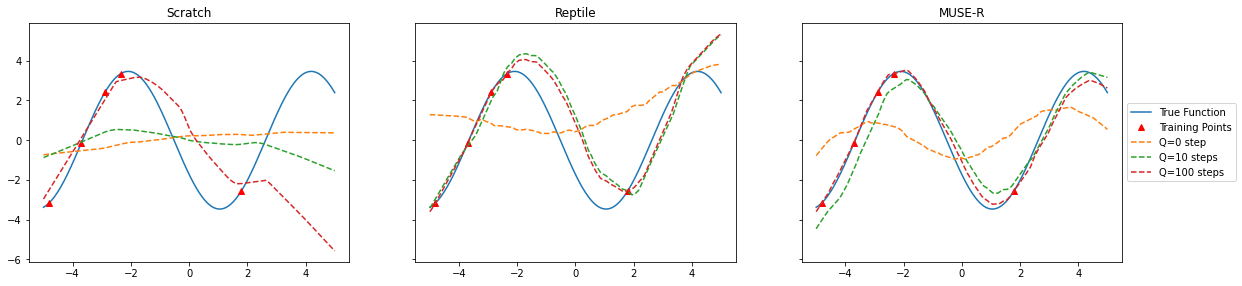

In [28]:
teC_reptile.eval()
predC_reptile = teC_reptile(nnewX_sp, nnewy_sp).detach().cpu().numpy()
best_modelC_reptile = np.argmax(predC_reptile)

_, history_scratch = adapt_and_evaluate(model_scratch, _, nnewX_sp, nnewy_sp, nnewX_qr, nnewy_qr, loss_fn, lr, steps=100, single_model=True, selection_steps=selection_steps)
_, history_bestmodelC_reptile = adapt_and_evaluate([modelsC_reptile[best_modelC_reptile]], None, nnewX_sp, nnewy_sp, nnewX_qr, nnewy_qr, loss_fn, lr, steps=100, single_model=True, selection_steps=selection_steps)
_, history_reptile = adapt_and_evaluate(modelA_reptile, None, nnewX_sp, nnewy_sp, nnewX_qr, nnewy_qr, loss_fn, lr, steps=100, single_model=True, selection_steps=selection_steps)

histories = [history_scratch, history_reptile, history_bestmodelC_reptile]
plot_regression_results_comparison1(nnewX_sp, nnewy_sp, nnewX_qr, nnewy_qr, histories, best_modelC_reptile, predC_reptile[0][best_modelC_reptile], save=f"{path_dir}/fitting_curves.png")

MMAML - model 1 
 Prediction probability = 99.6%


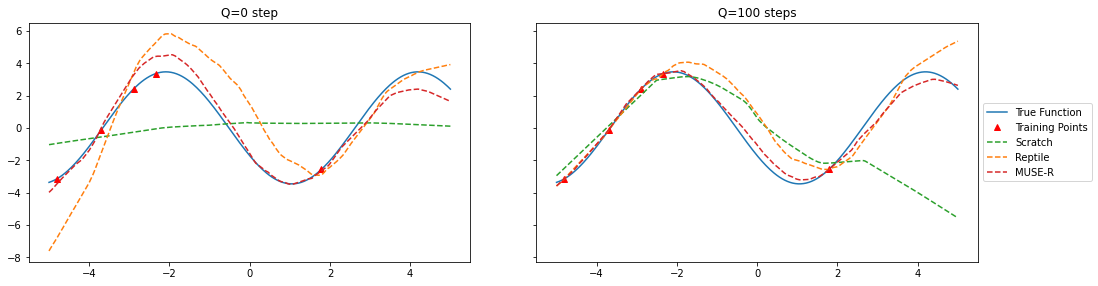

In [48]:
figure = plot_regression_results_comparison2(nnewX_sp, nnewy_sp, nnewX_qr, nnewy_qr, histories, best_modelC_reptile, predC_reptile[0][best_modelC_reptile], save=f"{path_dir}/fitting_curves2.png")

In [19]:
write_in_file(histories, f"{path_dir}/histories_fitting_curves")

In [46]:
figure.savefig(f"{path_dir}/prova.png", format='png', bbox_inches='tight') 